# Discover the data

In [178]:
import nltk
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [179]:
df = pd.read_csv("../src/emotions.csv")

In [180]:
df.sample(5)

,Text,Emotion
10575,i resent you as much as i do that i feel needl...,anger
9572,i feel agitated do i know how to quickly calm ...,anger
7970,i got to feel carefree on the ice with the col...,happy
7433,i really hate this feeling when you really giv...,anger
2302,i know i feel personally offended by this on s...,anger


In [181]:
df.head(5)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [182]:
df["Emotion"].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [183]:
# check the 5 most common words in the Text column
df["Text"].apply(lambda x: len(x.split())).sort_values(ascending=False).head(5)

6322    66
7222    64
9618    64
9626    64
46      64
Name: Text, dtype: int64

In [184]:
# rename columns
df.rename(columns={"Text": "text", "Emotion": "emotion"}, inplace=True)

In [185]:
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# NLTK

In [186]:
nltk.download("stopwords") # for stopwords
nltk.download("wordnet") # for lemmatization
nltk.download("punkt") # for tokenization

[nltk_data] Downloading package stopwords to /Users/ant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [187]:
stopwords_eng = set(stopwords.words("english"))

In [188]:
stopwords_eng

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## Lemmatizer

In [189]:
lemmatizer = WordNetLemmatizer()

In [190]:

def clean_text(text):
    """
    args: text - string
    returns: cleaned text
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_eng]
    return words

In [191]:
df['text_clean'] = df['text'].apply(clean_text)

In [192]:
df.head(5)

,text,emotion,text_clean
0,i didnt feel humiliated,sadness,"[didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,anger,"[im, grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,anger,"[feeling, grouchy]"


In [193]:
emotions_distribution = df['emotion'].value_counts()

In [194]:
emotion_words = {}
for emotion in df['emotion'].unique():
    words = []
    for text in df[df['emotion'] == emotion]['text_clean']:
        words.extend(text)
    emotion_words[emotion] = Counter(words).most_common(30)

In [195]:
emotion_words

{'sadness': [('feel', 4194),
  ('feeling', 2053),
  ('like', 1082),
  ('im', 875),
  ('really', 352),
  ('time', 351),
  ('know', 350),
  ('get', 299),
  ('day', 287),
  ('would', 273),
  ('thing', 268),
  ('little', 267),
  ('ive', 266),
  ('make', 266),
  ('want', 249),
  ('life', 244),
  ('one', 244),
  ('still', 243),
  ('even', 239),
  ('people', 231),
  ('think', 225),
  ('bit', 221),
  ('much', 191),
  ('dont', 190),
  ('way', 175),
  ('something', 170),
  ('back', 169),
  ('going', 164),
  ('could', 159),
  ('go', 150)],
 'anger': [('feel', 1856),
  ('feeling', 978),
  ('like', 480),
  ('im', 426),
  ('time', 175),
  ('really', 171),
  ('get', 167),
  ('know', 151),
  ('people', 150),
  ('want', 137),
  ('little', 136),
  ('thing', 136),
  ('even', 125),
  ('would', 118),
  ('angry', 116),
  ('one', 115),
  ('think', 113),
  ('way', 111),
  ('could', 108),
  ('make', 107),
  ('bit', 103),
  ('day', 97),
  ('offended', 92),
  ('dont', 91),
  ('resentful', 87),
  ('cold', 86),
  

In [196]:
vectorizer_tfidf = TfidfVectorizer()
data_tfidf = vectorizer_tfidf.fit_transform(df['text_clean'].apply(lambda x: ' '.join(x)))

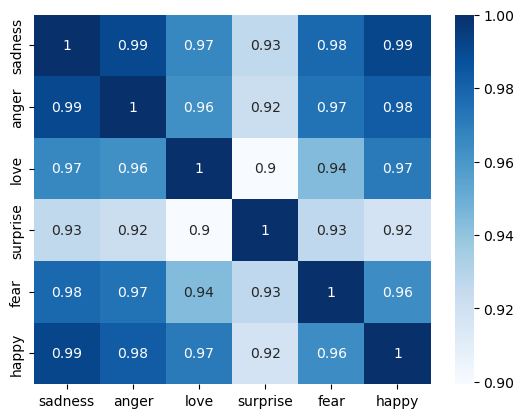

In [197]:
emotion_vectors = {}
for emotion, words in emotion_words.items():
    emotion_vectors[emotion] = np.zeros(len(vectorizer_tfidf.get_feature_names_out()))
    for word, count in words:
        if word in vectorizer_tfidf.vocabulary_:
            index = vectorizer_tfidf.vocabulary_[word]
            emotion_vectors[emotion][index] = count

emotion_similarity = cosine_similarity(list(emotion_vectors.values()))

sns.heatmap(emotion_similarity, xticklabels=emotion_vectors.keys(), yticklabels=emotion_vectors.keys(), annot=True, cmap='Blues')
plt.show()

# Create model - Logistic regressor

In [198]:
le = LabelEncoder()

In [199]:
df['emotion_encoded'] = le.fit_transform(df['emotion'])

In [200]:
df

,text,emotion,text_clean,emotion_encoded
0,i didnt feel humiliated,sadness,"[didnt, feel, humiliated]",4
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun...",4
2,im grabbing a minute to post i feel greedy wrong,anger,"[im, grabbing, minute, post, feel, greedy, wrong]",0
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st...",3
4,i am feeling grouchy,anger,"[feeling, grouchy]",0
...,...,...,...,...
21454,Melissa stared at her friend in dism,fear,"[melissa, stared, friend, dism]",1
21455,Successive state elections have seen the gover...,fear,"[successive, state, election, seen, governing,...",1
21456,Vincent was irritated but not dismay,fear,"[vincent, irritated, dismay]",1
21457,Kendall-Hume turned back to face the dismayed ...,fear,"[kendallhume, turned, back, face, dismayed, coup]",1


In [201]:
# # TF-IDF
# X_train, X_test, y_train, y_test = train_test_split(data_tfidf, df['emotion'], test_size=0.2, random_state=42)
# model_tfidf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
# model_tfidf_rf.fit(X_train, y_train)
# predictions_tfidf = model_tfidf_rf.predict(X_test)
# print("TF-IDF Model Performance with Random Forest:")
# print(classification_report(y_test, predictions_tfidf))

In [207]:
from sklearn.linear_model import LogisticRegression

# Create model - Logistic Regression
le = LabelEncoder()
df['emotion_encoded'] = le.fit_transform(df['emotion'])

# TF-IDF
X_train, X_test, y_train, y_test = train_test_split(data_tfidf, df['emotion_encoded'], test_size=0.2, random_state=42)

# Create and fit the model
model_tfidf_lr = LogisticRegression(max_iter=500, random_state=42)
model_tfidf_lr.fit(X_train, y_train)

# Make predictions on the test data
predictions_tfidf = model_tfidf_lr.predict(X_test)

print("TF-IDF Model Performance with Logistic Regression:")
print(classification_report(y_test, predictions_tfidf))

# Your new text
new_text = "I am over the moon! Everything is going perfectly today!"

# Preprocess the text
new_text_clean = clean_text(new_text)

# Transform the text into numeric vectors
new_text_vectorized = vectorizer_tfidf.transform([' '.join(new_text_clean)])

# Make a prediction
prediction = model_tfidf_lr.predict(new_text_vectorized)

# If your labels have been encoded, you can decode them to get the original label
prediction_label = le.inverse_transform(prediction)

# Mesure de confiance
confidence = np.max(model_tfidf_lr.predict_proba(new_text_vectorized))

print("Prediction:", prediction_label)
print("Confidence:", confidence)

TF-IDF Model Performance with Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       617
           1       0.87      0.78      0.83       531
           2       0.84      0.97      0.90      1381
           3       0.91      0.64      0.76       318
           4       0.89      0.95      0.92      1277
           5       0.86      0.53      0.65       168

    accuracy                           0.87      4292
   macro avg       0.88      0.78      0.82      4292
weighted avg       0.88      0.87      0.87      4292

Prediction: ['happy']
Confidence: 0.5105473511167136


In [205]:
# prediction_label = le.inverse_transform(prediction)
# print("Prediction:", prediction_label)
# print("Confidence:", confidence)

Prediction: ['happy']


In [ ]:
with open('../src/logistic_regressor_model.pkl', 'wb') as file:
    pickle.dump(model_tfidf_lr, file)